<a href="https://colab.research.google.com/github/alinaioanapopescu/popescu-alina-LA/blob/main/Proiect_LA_Popescu_Alina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Kaggle dataset page:
# https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction

import os, json, glob
from getpass import getpass

# 1) Create kaggle.json from typed credentials (no file upload)
KAGGLE_USERNAME = input("Kaggle username: ").strip()
KAGGLE_KEY = getpass("Kaggle API key (paste, hidden): ").strip()

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
os.chmod("/root/.kaggle/kaggle.json", 0o600)

# 2) Download + unzip
DATASET = "teejmahal20/airline-passenger-satisfaction"
DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

!pip -q install kaggle
!kaggle datasets download -d {DATASET} -p {DATA_DIR} --unzip

print("\n=== Files in /content/data ===")
!ls -lah /content/data

# 3) Quick preview with pandas
import pandas as pd
csv_files = sorted(glob.glob(f"{DATA_DIR}/*.csv"))
print("\nCSV files:", csv_files)

csv_path = csv_files[0]
print("\nPreview from:", csv_path)
pdf = pd.read_csv(csv_path)
print("Shape:", pdf.shape)
display(pdf.head(10))


Kaggle username: alinapopescu
Kaggle API key (paste, hidden): ··········
Dataset URL: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction
License(s): other
  0% 0.00/2.71M [00:00<?, ?B/s]
100% 2.71M/2.71M [00:00<00:00, 763MB/s]

=== Files in /content/data ===
total 15M
drwxr-xr-x 2 root root 4.0K Jan 28 20:18 .
drwxr-xr-x 1 root root 4.0K Jan 28 19:17 ..
-rw-r--r-- 1 root root 2.9M Jan 28 20:18 test.csv
-rw-r--r-- 1 root root  12M Jan 28 20:18 train.csv

CSV files: ['/content/data/test.csv', '/content/data/train.csv']

Preview from: /content/data/test.csv
Shape: (25976, 25)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied
5,5,39177,Male,Loyal Customer,16,Business travel,Eco,311,3,3,...,5,4,3,1,1,2,5,0,0.0,satisfied
6,6,79433,Female,Loyal Customer,77,Business travel,Business,3987,5,5,...,5,5,5,5,4,5,3,0,0.0,satisfied
7,7,97286,Female,Loyal Customer,43,Business travel,Business,2556,2,2,...,4,4,4,4,5,4,3,77,65.0,satisfied
8,8,27508,Male,Loyal Customer,47,Business travel,Eco,556,5,2,...,5,2,2,5,3,3,5,1,0.0,satisfied
9,9,62482,Female,Loyal Customer,46,Business travel,Business,1744,2,2,...,4,4,4,4,5,4,4,28,14.0,satisfied


In [12]:
# curatare si preprocesare (pyspark) pentru airline passenger satisfaction

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

spark = SparkSession.builder.appName("airline_satisfaction").getOrCreate()

data_dir = "/content/data"
train_path = f"{data_dir}/train.csv"
test_path  = f"{data_dir}/test.csv"

train_df = spark.read.option("header", True).option("inferSchema", True).csv(train_path)
test_df  = spark.read.option("header", True).option("inferSchema", True).csv(test_path)

drop_cols = [c for c in ["Unnamed: 0", "id"] if c in train_df.columns]
train_df = train_df.drop(*drop_cols)
test_df  = test_df.drop(*drop_cols)

#  construire label binar (satisfied=1, altfel 0) si eliminare coloana originala
train_df = train_df.withColumn("label", when(col("satisfaction") == "satisfied", 1).otherwise(0)).drop("satisfaction")
test_df  = test_df.withColumn("label", when(col("satisfaction") == "satisfied", 1).otherwise(0)).drop("satisfaction")

train_df = train_df.dropna()
test_df  = test_df.dropna()


cat_cols = [c for c, t in train_df.dtypes if t == "string" and c != "label"]
num_cols = [c for c, t in train_df.dtypes if t != "string" and c != "label"]

indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in cat_cols
]
encoder = OneHotEncoder(
    inputCols=[f"{c}_idx" for c in cat_cols],
    outputCols=[f"{c}_ohe" for c in cat_cols]
)

assembler = VectorAssembler(
    inputCols=num_cols + [f"{c}_ohe" for c in cat_cols],
    outputCol="features",
    handleInvalid="keep"
)

prep_pipeline = Pipeline(stages=indexers + [encoder, assembler])
prep_model = prep_pipeline.fit(train_df)

train_prepared = prep_model.transform(train_df).select("label", "features")
test_prepared  = prep_model.transform(test_df).select("label", "features")

print("prepared train rows:", train_prepared.count())
print("prepared test rows :", test_prepared.count())
train_prepared.show(5, truncate=False)


prepared train rows: 103594
prepared test rows : 25893
+-----+----------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                              |
+-----+----------------------------------------------------------------------------------------------------------------------+
|0    |[0.0,13.0,460.0,3.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,25.0,18.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0]|
|0    |[1.0,25.0,235.0,3.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,1.0,6.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0]  |
|1    |[2.0,26.0,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0] |
|0    |[3.0,25.0,562.0,2.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0,11.0,9.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0] |
|1    |[4.0,61.0,214.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3

In [13]:
# citire + curatare + split (train/val/test)

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

spark = SparkSession.builder.appName("airline_satisfaction_project").getOrCreate()

data_dir = "/content/data"
train_path = f"{data_dir}/train.csv"
test_path  = f"{data_dir}/test.csv"

train_df_raw = spark.read.option("header", True).option("inferSchema", True).csv(train_path)
test_df_raw  = spark.read.option("header", True).option("inferSchema", True).csv(test_path)

# curatare minima + label binar
def prepare_base_df(df):
    drop_cols = [c for c in ["Unnamed: 0", "id"] if c in df.columns]
    df = df.drop(*drop_cols)

    # label: 1=satisfied, 0=neutral or dissatisfied
    df = df.withColumn("label", when(col("satisfaction") == "satisfied", 1).otherwise(0)).drop("satisfaction")

    # simplu: eliminare randuri cu null
    df = df.dropna()
    return df

train_df = prepare_base_df(train_df_raw).cache()
test_df  = prepare_base_df(test_df_raw).cache()

# split train -> train/val (test ramane separat)
train_split, val_split = train_df.randomSplit([0.8, 0.2], seed=42)
train_split = train_split.cache()
val_split   = val_split.cache()

print("rows: train_df =", train_df.count(), "| train_split =", train_split.count(), "| val_split =", val_split.count(), "| test_df =", test_df.count())
print("cols:", len(train_df.columns))


rows: train_df = 103594 | train_split = 82816 | val_split = 20778 | test_df = 25893
cols: 24


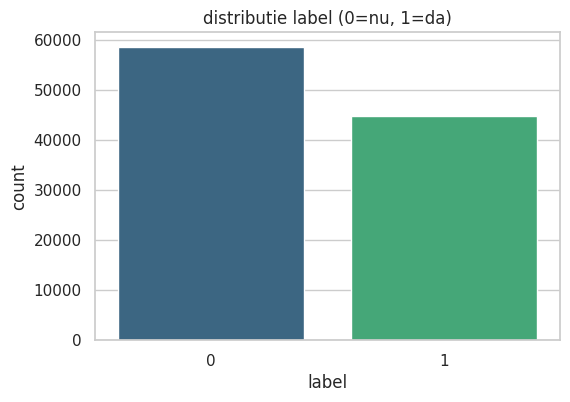

antrenare: linearsvc...
antrenare: randomforest...
antrenare: gbt...
antrenare: naive_bayes...

rezultate finale (test):
          model       auc
2           gbt  0.989032
1  randomforest  0.971062
0     linearsvc  0.925990
3   naive_bayes  0.290116


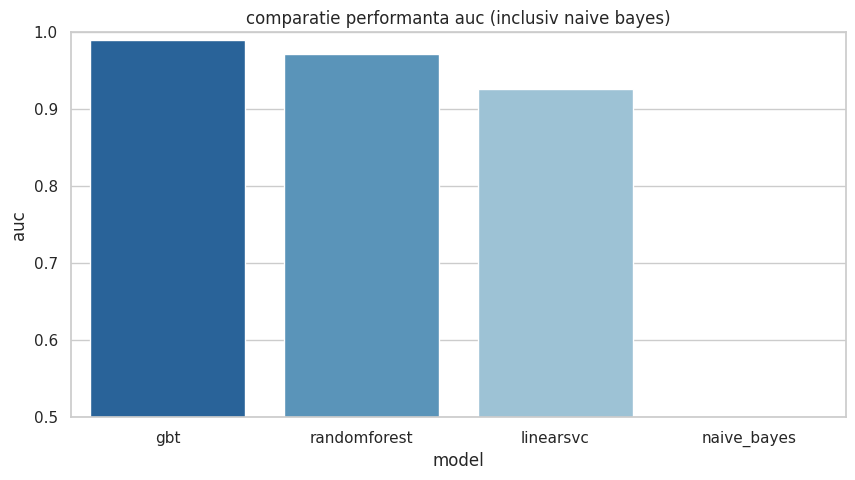

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as f
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LinearSVC, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# setari vizuale
sns.set_theme(style="whitegrid")

# 1. analiza exploratorie (eda)
def ruleaza_eda(df):
    label_pdf = df.groupBy("label").count().toPandas()
    plt.figure(figsize=(6, 4))
    sns.barplot(x="label", y="count", data=label_pdf, hue="label", legend=False, palette="viridis")
    plt.title("distributie label (0=nu, 1=da)")
    plt.show()

# 2. constructie pipeline si antrenare (cu naive bayes inclus)
def antrenare_modele(train_df, test_df):
    cols_cat = [c for c, t in train_df.dtypes if t == "string" and c != "label"]
    cols_num = [c for c, t in train_df.dtypes if t != "string" and c != "label"]

    indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in cols_cat]
    encoder = OneHotEncoder(inputCols=[f"{c}_idx" for c in cols_cat], outputCols=[f"{c}_ohe" for c in cols_cat])
    assembler = VectorAssembler(inputCols=cols_num + [f"{c}_ohe" for c in cols_cat], outputCol="features_raw")

    # naive bayes are nevoie obligatoriu de scalare (toate valorile sa fie pozitive)
    scaler = MinMaxScaler(inputCol="features_raw", outputCol="features_scaled")

    etape_baza = indexers + [encoder, assembler, scaler]

    # am adaugat naive bayes in lista
    lista_modele = [
        ("linearsvc", LinearSVC(featuresCol="features_scaled", labelCol="label", maxIter=20)),
        ("randomforest", RandomForestClassifier(featuresCol="features_raw", labelCol="label", numTrees=100)),
        ("gbt", GBTClassifier(featuresCol="features_raw", labelCol="label", maxIter=40)),
        ("naive_bayes", NaiveBayes(featuresCol="features_scaled", labelCol="label", modelType="multinomial"))
    ]

    rezultate = []
    modele_instruite = {}
    evaluator_auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

    for nume, clf in lista_modele:
        print(f"antrenare: {nume}...")
        pipe = Pipeline(stages=etape_baza + [clf])
        model_fit = pipe.fit(train_df)
        modele_instruite[nume] = model_fit

        predictii = model_fit.transform(test_df)
        auc = evaluator_auc.evaluate(predictii)
        rezultate.append({"model": nume, "auc": auc})

    return pd.DataFrame(rezultate), modele_instruite, (cols_num + [f"{c}_ohe" for c in cols_cat])

# 3. vizualizare performanta
def afiseaza_rezultate(rez_df):
    plt.figure(figsize=(10, 5))
    sns.barplot(x="model", y="auc", data=rez_df.sort_values("auc", ascending=False),
                hue="model", legend=False, palette="Blues_r")
    plt.title("comparatie performanta auc (inclusiv naive bayes)")
    plt.ylim(0.5, 1.0) # naive bayes s-ar putea sa aiba scor mai mic, deci pornim de la 0.5
    plt.show()

# --- executie ---
ruleaza_eda(train_df)
metrice_df, toate_pipelineurile, nume_coloane = antrenare_modele(train_df, test_df)

print("\nrezultate finale (test):")
print(metrice_df.sort_values("auc", ascending=False))

afiseaza_rezultate(metrice_df)

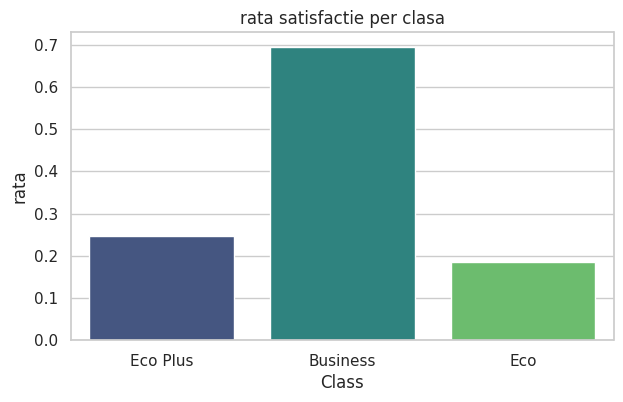

antrenare: linearsvc...
antrenare: random_forest...
antrenare: gbt...
antrenare: naive_bayes...

--- rezultate auc ---
           model       auc
2            gbt  0.989032
1  random_forest  0.971062
0      linearsvc  0.925990
3    naive_bayes  0.290116


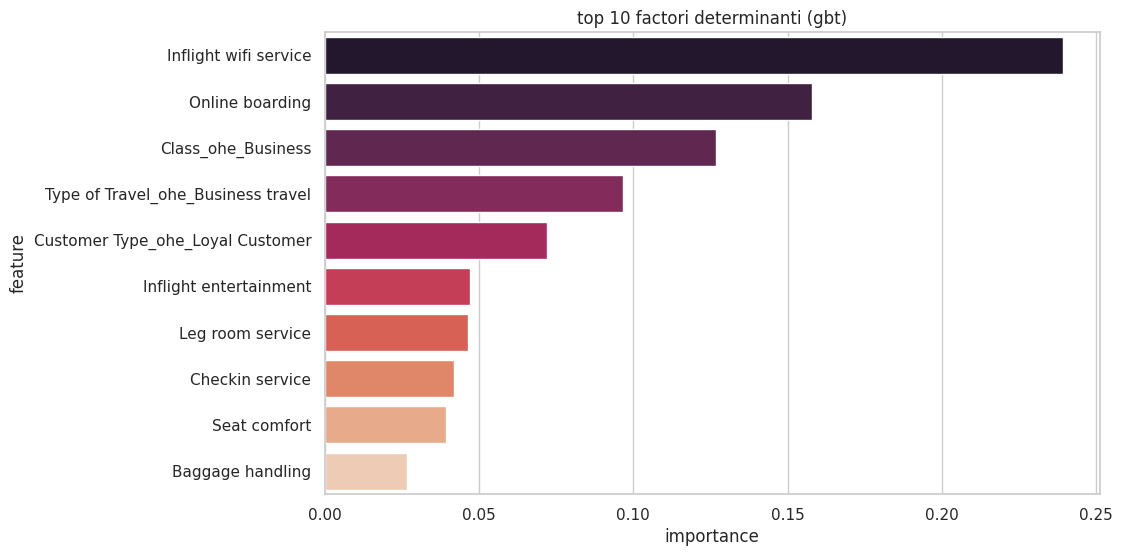

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as f
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LinearSVC, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# setari vizuale
sns.set_theme(style="whitegrid")

# 1. eda rapid pe datele de pe kaggle
def ruleaza_eda(df):
    # satisfactie vs clasa (eco/business)
    pdf_class = df.groupBy("Class").agg(f.avg("label").alias("rata")).toPandas()
    plt.figure(figsize=(7, 4))
    sns.barplot(data=pdf_class, x="Class", y="rata", hue="Class", palette="viridis", legend=False)
    plt.title("rata satisfactie per clasa")
    plt.show()

# 2. ml pipeline si antrenare
def antrenare_modele(train_df, test_df):
    # curatare obligatorie pentru dataset-ul airline
    train_df = train_df.na.fill(0)
    test_df = test_df.na.fill(0)

    cols_cat = [c for c, t in train_df.dtypes if t == "string" and c != "label"]
    cols_num = [c for c, t in train_df.dtypes if t != "string" and c != "label"]

    # preprocesare
    indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in cols_cat]
    encoder = OneHotEncoder(inputCols=[f"{c}_idx" for c in cols_cat], outputCols=[f"{c}_ohe" for c in cols_cat])

    # asamblare (folosim 'features' pentru toate modelele pentru simplitate)
    assembler = VectorAssembler(inputCols=cols_num + [f"{c}_ohe" for c in cols_cat], outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

    preproc_stages = indexers + [encoder, assembler, scaler]

    # definitie modele
    modele_lista = [
        ("linearsvc", LinearSVC(featuresCol="features_scaled", labelCol="label", maxIter=20)),
        ("random_forest", RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)),
        ("gbt", GBTClassifier(featuresCol="features", labelCol="label", maxIter=40)),
        ("naive_bayes", NaiveBayes(featuresCol="features_scaled", labelCol="label"))
    ]

    rezultate = []
    pipe_dict = {}
    evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

    for nume, clf in modele_lista:
        print(f"antrenare: {nume}...")
        p = Pipeline(stages=preproc_stages + [clf])
        m = p.fit(train_df)
        pipe_dict[nume] = m

        preds = m.transform(test_df)
        auc = evaluator.evaluate(preds)
        rezultate.append({"model": nume, "auc": auc})

    return pd.DataFrame(rezultate), pipe_dict

# 3. functie corecta pentru importanta trasaturilor
def afiseaza_importanta_final(model_pipe, train_df):
    # extragem numele corecte ale trasaturilor din metadata
    # transformam un singur rand ca sa accesam schema
    schema = model_pipe.transform(train_df.limit(1)).schema

    # gasim campul 'features' in schema
    features_field = [f for f in schema.fields if f.name == "features"][0]

    # extragem numele atributelor din metadata
    attrs = features_field.metadata['ml_attr']['attrs']
    list_attrs = attrs.get('numeric', []) + attrs.get('binary', []) + attrs.get('nominal', [])

    # sortam dupa index ca sa coincida cu array-ul de importanta
    nume_trasaturi = [x['name'] for x in sorted(list_attrs, key=lambda x: x['idx'])]

    # extragem importante din modelul gbt
    model_intern = model_pipe.stages[-1]
    importante = model_intern.featureImportances.toArray()

    imp_df = pd.DataFrame({'feature': nume_trasaturi, 'importance': importante})
    imp_df = imp_df.sort_values("importance", ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=imp_df, x="importance", y="feature", hue="feature", palette="rocket", legend=False)
    plt.title("top 10 factori determinanti (gbt)")
    plt.show()

# --- flux executie ---
ruleaza_eda(train_df)

rez_df, pipes = antrenare_modele(train_df, test_df)

print("\n--- rezultate auc ---")
print(rez_df.sort_values("auc", ascending=False))

# apelam functia folosind noul sistem de accesare metadata
afiseaza_importanta_final(pipes["gbt"], train_df)